In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly
import plotly.plotly as py
from scipy import stats
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import sklearn.metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
from functools import reduce
from operator import and_
import operator
import time

C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



In [2]:
plot_params = {'legend.fontsize': 'x-large',
               'figure.figsize': (10, 8),
               'axes.labelsize': 'x-large',
               'axes.titlesize':'x-large',
               'xtick.labelsize':'x-large',
               'ytick.labelsize':'x-large'}
for param, value in plot_params.items():
    mpl.rcParams[param] = value

# Initialization and definitions

In [3]:
dfs = {} # dict of data frames for each year
filtered_dfs = {} # dict of data frames with processed and filtered columns
model_dfs = {} # raw data for fit
model_filtered_dfs = {} # filtered data for fit

In [4]:
state_dict = { 1: 'AL',  2: 'AK',  4: 'AZ',  5: 'AR',  6: 'CA',  8: 'CO',  9: 'CT',
              10: 'DE', 12: 'FL', 13: 'GA', 15: 'HI', 16: 'ID', 17: 'IL', 18: 'IN',
              19: 'IA', 20: 'KS', 21: 'KY', 22: 'LA', 23: 'ME', 24: 'MD', 25: 'MA',
              26: 'MI', 27: 'MN', 28: 'MS', 29: 'MO', 30: 'MT', 31: 'NE', 32: 'NV',
              33: 'NH', 34: 'NJ', 35: 'NM', 36: 'NY', 37: 'NC', 38: 'ND', 39: 'OH',
              40: 'OK', 41: 'OR', 42: 'PA', 44: 'RI', 45: 'SC', 46: 'SD', 47: 'TN',
              48: 'TX', 49: 'UT', 50: 'VT', 51: 'VA', 53: 'WA', 54: 'WV', 55: 'WI',
              56: 'WY'}
states = list(state_dict.values())

factors = ['NonDrinker', 'NonSmoker', 'NotOverweight', 'Exercises',
           'State', 'EnoughSleep', 'NoDepressive']
model_factors = ['NoPhys14D', 'NoMent14D', 'HasHealthPlan', 'MedCostOK',
                 'Checkup1Yr', 'Exercises', 'EnoughSleep', 'NeverHeartAttack',
                 'NeverHeartDisease', 'NeverStroke', 'NoAsthma',
                 'NoOtherCancer', 'NoCOPD', 'NoArthritis', 'NoDepressive',
                 'NoKidneyDisease', 'NoDiabetes', 'Dentist1Yr', 'NoTeethRemoved',
                 'AttendedCollege', 'Veteran', 'ChildrenInHousehold', 'NotOverweight',
                 'NotDeaf', 'NotBlind', 'DecisionOK', 'DressOK',
                 'WalkOK', 'AloneOK', 'NonSmoker', 'NonECig', 'NonDrinker',
                 'AlwaysSeatbelt', 'NoHIVRisk',
                 '_INCOMG',
                 'NoSkinCancer', 'FluShot1Yr', 'TestedHIV', 'HasDoctor'
                ]

value_filter = {'_STATE': state_dict.keys(),
                'GENHLTH': [1,2,3,4,5],
                '_PHYS14D': [1,2,3],
                '_MENT14D': [1,2,3],
                'HLTHPLN1': [1,2],
                'PERSDOC2': [1,2,3],
                'MEDCOST': [1,2],
                'CHECKUP1': [1,2,3,4],
                'EXERANY2': [1,2],
                'SLEPTIM1': range(1, 25),
                'CVDINFR4': [1,2],
                'CVDCRHD4': [1,2],
                'CVDSTRK3': [1,2],
                '_ASTHMS1': [1,2,3],
                'CHCSCNCR': [1,2],
                'CHCOCNCR': [1,2],
                'CHCCOPD1': [1,2],
                'HAVARTH3': [1,2],
                'ADDEPEV2': [1,2],
                'CHCKIDNY': [1,2],
                'DIABETE3': [1,2,3,4],
                '_DENVST2': [1,2],
                'RMVTETH3': [1,2,3,8],
                'EDUCA': [1,2,3,4,5,6],
                'VETERAN3': [1,2],
                'CHILDREN': range(1, 89),
                '_INCOMG': [1,2,3,4,5],
                '_RFBMI5': [1,2],
                '_BMI5CAT': [1,2,3,4],
                'DEAF': [1,2],
                'BLIND': [1,2],
                'DECIDE': [1,2],
                'DIFFWALK': [1,2],
                'DIFFDRES': [1,2],
                'DIFFALON': [1,2],
                '_RFSMOK3': [1,2],
                'ECIGARET': [1,2],
                '_CURECIG': [1,2],
                'DRNKANY5': [1,2],
                'FLUSHOT6': [1,2],
                'SEATBELT': [1,2,3,4,5,8],
                'BLDSTOOL': [1,2,0],
                'HADSIGM3': [1,2,0],
                'HIVTST6': [1,2],
                'HIVRISK4': [1,2]
               }

f_convert = {'State': ['_STATE', state_dict],
             'VeryGoodHealth': ['GENHLTH', {1: True, 2: True, 3: False, 4: False, 5: False}],
             'GoodHealth': ['GENHLTH', {1: True, 2: True, 3: True, 4: False, 5: False}],
             'NoPhys14D': ['_PHYS14D', {1: True, 2: False, 3: False}],
             'NoMent14D': ['_MENT14D', {1: True, 2: False, 3: False}],
             'HasHealthPlan': ['HLTHPLN1', {1: True, 2: False}],
             'HasDoctor': ['PERSDOC2', {1: True, 2: True, 3: False}],
             'MedCostOK': ['MEDCOST', {2: True, 1: False}],
             'Checkup1Yr': ['CHECKUP1', {1: True, 2: False, 3: False, 4: False}],
             'Exercises': ['EXERANY2', {1: True, 2: False}],
             'EnoughSleep': ['SLEPTIM1', {h: (h >= 8) for h in range(1, 25)}],
             'NeverHeartAttack': ['CVDINFR4', {2: True, 1: False}],
             'NeverHeartDisease': ['CVDCRHD4', {2: True, 1: False}],
             'NeverStroke': ['CVDSTRK3', {2: True, 1: False}],
             'NoAsthma': ['_ASTHMS1', {2: True, 3: True, 1: False}],
             'NoSkinCancer': ['CHCSCNCR', {2: True, 1: False}],
             'NoOtherCancer': ['CHCOCNCR', {2: True, 1: False}],
             'NoCOPD': ['CHCCOPD1', {2: True, 1: False}],
             'NoArthritis': ['HAVARTH3', {2: True, 1: False}],
             'NoDepressive': ['ADDEPEV2', {2: True, 1: False}],
             'NoKidneyDisease': ['CHCKIDNY', {2: True, 1: False}],
             'NoDiabetes': ['DIABETE3', {2: True, 3: True, 4: True, 1: False}],
             'Dentist1Yr': ['_DENVST2', {1: True, 2: False}],
             'NoTeethRemoved': ['RMVTETH3', {8: True, 1: False, 2: False, 3: False}],
             'AttendedCollege': ['EDUCA', {5: True, 6: True, 1: False, 2: False, 3: False, 4: False}],
             'Veteran': ['VETERAN3', {1: True, 2: False}],
             'ChildrenInHousehold': ['CHILDREN', {c: (c != 88) for c in range(1, 89)}],
             'NotOverweight': ['_RFBMI5', {1: True, 2: False}],
             'NotUnderweight': ['_BMI5CAT', {2: True, 1: False}],
             'NotDeaf': ['DEAF', {2: True, 1: False}],
             'NotBlind': ['BLIND', {2: True, 1: False}],
             'DecisionOK': ['DECIDE', {2: True, 1: False}],
             'DressOK': ['DIFFDRES', {2: True, 1: False}],
             'WalkOK': ['DIFFWALK', {2: True, 1: False}],
             'AloneOK': ['DIFFALON', {2: True, 1: False}],
             'NonSmoker': ['_RFSMOK3', {1: True, 2: False}],
             'NonECig': ['_CURECIG', {1: True, 2: False}],
             'NonDrinker': ['DRNKANY5', {2: True, 1: False}],
             'FluShot1Yr': ['FLUSHOT6', {1: True, 2: False}],
             'AlwaysSeatbelt': ['SEATBELT', {1: True, 8: True, 2: False, 3: False, 4: False, 5: False}],
             'TestedHIV': ['HIVTST6', {1: True, 2: False}],
             'NoHIVRisk': ['HIVRISK4', {2: True, 1: False}]
            }

f_label = {'NotOverweight': 'Not overweight',
           'NonSmoker': 'Non-smoker',
           'NoDepressive': 'No depressive disorder',
           'Exercises': 'Exercises regularly',
           'EnoughSleep': '8+ hours of sleep'
          }

In [5]:
def load_data(year):
    print('Loading data for year ' + str(year))
    layout_fname = 'C:/Users/Michael/Documents/data incubator application/brfss' + str(year) + '_layout.csv'
    data_fname = 'C:/Users/Michael/Documents/data incubator application/LLCP' + str(year) + '.ASC'
    layout = pd.read_csv(layout_fname, names=['StartCol', 'Name', 'Length'])
    keep_columns = (['GENHLTH'] +
                    [f_convert[f][0] for f in factors if f in f_convert.keys()] +
                    [f for f in factors if f not in f_convert.keys()])
    layout_filtered = layout[layout['Name'].isin(keep_columns)]
    colspecs = list(zip(layout_filtered['StartCol'] - 1,
                        layout_filtered['StartCol'] + layout_filtered['Length'] - 1))
    df = pd.read_fwf(data_fname, colspecs=colspecs,
                     header=None, names=layout_filtered['Name'])
#     df = df[~df['_STATE'].isin([11, 66, 72, 78])] # Drop DC, Guam, Puerto Rico, Virgin Islands
#     df['State'] = df['_STATE'].replace(state_dict)
    print('Finished loading data for year ' + str(year))
    return df

def load_data_model(year):
    # Load data with more columns for use in model fitting.
    print('Loading data for year ' + str(year))
    layout_fname = 'C:/Users/Michael/Documents/data incubator application/brfss' + str(year) + '_layout.csv'
    data_fname = 'C:/Users/Michael/Documents/data incubator application/LLCP' + str(year) + '.ASC'
    layout = pd.read_csv(layout_fname, names=['StartCol', 'Name', 'Length'])
    keep_columns = (['GENHLTH', '_STATE'] +
                    [f_convert[f][0] for f in model_factors if f in f_convert.keys()] +
                    [f for f in model_factors if f not in f_convert.keys()])
    layout_filtered = layout[layout['Name'].isin(keep_columns)]
    colspecs = list(zip(layout_filtered['StartCol'] - 1,
                        layout_filtered['StartCol'] + layout_filtered['Length'] - 1))
    df = pd.read_fwf(data_fname, colspecs=colspecs,
                     header=None, names=layout_filtered['Name'])
    print('Finished loading data for year ' + str(year))
    return df

def filter_for_map(year, factor):
    final_columns = ['GENHLTH', 'State', factor]
    keep_columns = []
    
    # Identify raw and processed final columns
    for col in final_columns:
        if col in dfs[year].columns:
            keep_columns += [col]
        else:
            keep_columns += [f_convert[col][0]]
    df = dfs[year][keep_columns]
    
    # Remove unwanted values
    df = df[reduce(and_, [df[col].isin(value_filter[col]) for col in df.columns])]
    
    # Create processed columns
    for col in final_columns:
        if col not in dfs[year].columns:
            df[col] = df[f_convert[col][0]].map(f_convert[col][1])
            
    return df

def filter_for_bar(years, factors, group=None):
    final_columns = ['GENHLTH'] + factors
    if group is not None:
        final_columns += [group]
    keep_columns = []
    dfs_filtered = {}
    
    for i, year in enumerate(years):
        
        # Identify raw and processed final columns
        if i == 0:
            for col in final_columns:
                if col in dfs[year].columns:
                    keep_columns += [col]
                else:
                    keep_columns += [f_convert[col][0]]

        df = dfs[year][keep_columns]

        # Remove unwanted values
        df = df[reduce(and_, [df[col].isin(value_filter[col]) for col in df.columns])]

        # Create processed columns
        for col in final_columns:
            if col not in dfs[year].columns:
                df[col] = df[f_convert[col][0]].map(f_convert[col][1])
        
        dfs_filtered[year] = df

    return dfs_filtered

def filter_for_model(year, group=None):
    final_columns = ['GENHLTH', 'VeryGoodHealth', 'GoodHealth', 'State'] + model_factors
    if group is not None:
        final_columns += [group]
    keep_columns = []
    
    # Identify raw and processed final columns
    for col in final_columns:
        if col in model_dfs[year].columns:
            if col not in keep_columns:
                keep_columns += [col]
        else:
            if f_convert[col][0] not in keep_columns:
                keep_columns += [f_convert[col][0]]

    df = model_dfs[year][keep_columns]

    # Remove unwanted values
    print('Before filtering: df length is ' + str(len(df)))
    df = df[reduce(and_, [df[col].isin(value_filter[col]) for col in df.columns])]
    print('After filtering: df length is ' + str(len(df)))

    # Create processed columns
    for col in final_columns:
        if col not in model_dfs[year].columns:
            df[col] = df[f_convert[col][0]].map(f_convert[col][1])

    return df

# Yearly trends

In [6]:
years = range(2012, 2017)
for year in years:
    if year not in dfs.keys():
        dfs[year] = load_data(year)
bar_factors = ['NotOverweight', 'NonSmoker', 'Exercises', 'NonDrinker', 'NoDepressive']
filtered_dfs = filter_for_bar(years, factors=bar_factors, group='State')

Loading data for year 2012
Finished loading data for year 2012
Loading data for year 2013
Finished loading data for year 2013
Loading data for year 2014
Finished loading data for year 2014
Loading data for year 2015
Finished loading data for year 2015
Loading data for year 2016
Finished loading data for year 2016


In [7]:
agg_results = {}

for year in years:
    agg_results[year] = {}
    df = filtered_dfs[year]

    print('\n' + str(year) + ':')
    for factor in bar_factors:
        truedata = df['GENHLTH'][df[factor] == True]
        falsedata = df['GENHLTH'][df[factor] == False]
        truelevel = np.mean(truedata)
        falselevel = np.mean(falsedata)
        se = np.sqrt(np.std(truedata)**2 / len(truedata) + 
                     np.std(falsedata)**2 / len(falsedata))
        tstar = stats.t.ppf(0.975, min(len(truedata), len(falsedata)) - 1)
        print('Mean GENHLTH for {} = True (sample size {}): {}'.format(
            factor, len(truedata), truelevel))
        print('Mean GENHLTH for {} = False (sample size {}): {}'.format(
            factor, len(falsedata), falselevel))
        print('Difference = {}'.format(falselevel - truelevel))
        print('Standard Error = {}'.format(se))
        agg_results[year][factor] = falselevel - truelevel
        agg_results[year][factor + '_err'] = tstar * se


2012:
Mean GENHLTH for NotOverweight = True (sample size 148869): 2.3278318521653265
Mean GENHLTH for NotOverweight = False (sample size 273022): 2.6961673418259333
Difference = 0.3683354896606068
Standard Error = 0.0035445712120234837
Mean GENHLTH for NonSmoker = True (sample size 351969): 2.496722722739787
Mean GENHLTH for NonSmoker = False (sample size 69922): 2.9159062955865105
Difference = 0.4191835728467237
Standard Error = 0.004610405532407611
Mean GENHLTH for Exercises = True (sample size 319619): 2.3765045257009128
Mean GENHLTH for Exercises = False (sample size 102272): 3.159017130788486
Difference = 0.782512605087573
Standard Error = 0.004011413564671401
Mean GENHLTH for NonDrinker = True (sample size 205103): 2.820075766809847
Mean GENHLTH for NonDrinker = False (sample size 216788): 2.326000516633762
Difference = -0.4940752501760848
Standard Error = 0.0033298081443182584
Mean GENHLTH for NoDepressive = True (sample size 342586): 2.437008517569311
Mean GENHLTH for NoDepres

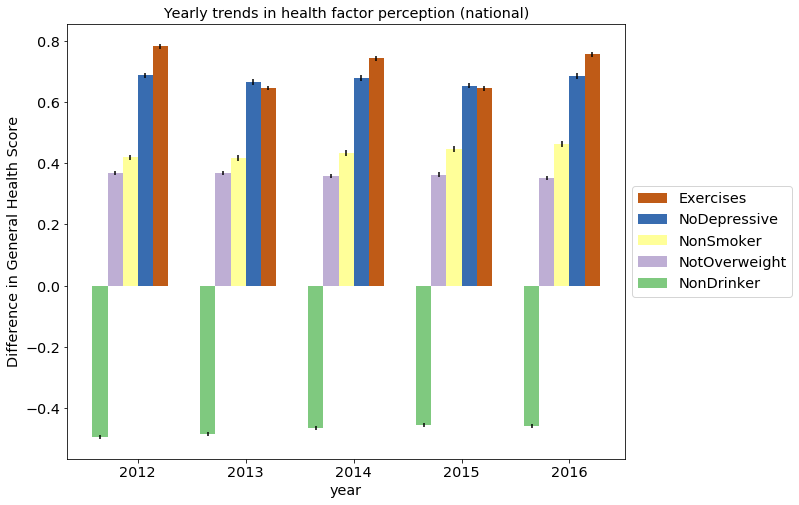

In [8]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

space = 0.3

bar_means = [np.mean([agg_results[year][factor] for year in years]) for factor in bar_factors]
variables = [factor for _,factor in sorted(zip(bar_means, bar_factors))]
groups = years

n = len(variables)

width = (1 - space) / (len(variables))

for i, var in enumerate(variables):
    values = [agg_results[year][var] for year in years]
    err = [agg_results[year][var + '_err'] for year in years]
    pos = [j - (1 - space) / 2. + i * width for j in range(1, len(groups)+1)]
    ax.bar(pos, values, width=width, label=var, color=cm.Accent(float(i) / n), yerr=err)

ax.set_xticks(range(1, len(groups)+1))
ax.set_xticklabels(groups)
ax.set_xlabel('year')
ax.set_ylabel('Difference in General Health Score')
ax.set_title('Yearly trends in health factor perception (national)')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [11]:
agg_results = {}
state = 'MA'

for year in years:
    agg_results[year] = {}
    df = filtered_dfs[year][filtered_dfs[year]['State'] == state]

    print('\n' + str(year) + ':')
    for factor in bar_factors:
        truedata = df['GENHLTH'][df[factor] == True]
        falsedata = df['GENHLTH'][df[factor] == False]
        truelevel = np.mean(truedata)
        falselevel = np.mean(falsedata)
        se = np.sqrt(np.std(truedata)**2 / len(truedata) + 
                     np.std(falsedata)**2 / len(falsedata))
        tstar = stats.t.ppf(0.975, min(len(truedata), len(falsedata)) - 1)
        print('Mean GENHLTH for {} = True (sample size {}): {}'.format(
            factor, len(truedata), truelevel))
        print('Mean GENHLTH for {} = False (sample size {}): {}'.format(
            factor, len(falsedata), falselevel))
        print('Difference = {}'.format(falselevel - truelevel))
        print('Standard Error = {}'.format(se))
        agg_results[year][factor] = falselevel - truelevel
        agg_results[year][factor + '_err'] = tstar * se


2012:
Mean GENHLTH for NotOverweight = True (sample size 7378): 2.2198427758200054
Mean GENHLTH for NotOverweight = False (sample size 11608): 2.614145416953825
Difference = 0.3943026411338195
Standard Error = 0.016074445956596482
Mean GENHLTH for NonSmoker = True (sample size 16017): 2.3888992944995944
Mean GENHLTH for NonSmoker = False (sample size 2969): 2.849444257325699
Difference = 0.4605449628261047
Standard Error = 0.02167204949430514
Mean GENHLTH for Exercises = True (sample size 14780): 2.2837618403247633
Mean GENHLTH for Exercises = False (sample size 4206): 3.0834522111269616
Difference = 0.7996903708021983
Standard Error = 0.019580243562505702
Mean GENHLTH for NonDrinker = True (sample size 7382): 2.8047954483879707
Mean GENHLTH for NonDrinker = False (sample size 11604): 2.242157876594278
Difference = -0.5626375717936929
Standard Error = 0.016350231361947548
Mean GENHLTH for NoDepressive = True (sample size 15018): 2.3255426821147958
Mean GENHLTH for NoDepressive = False

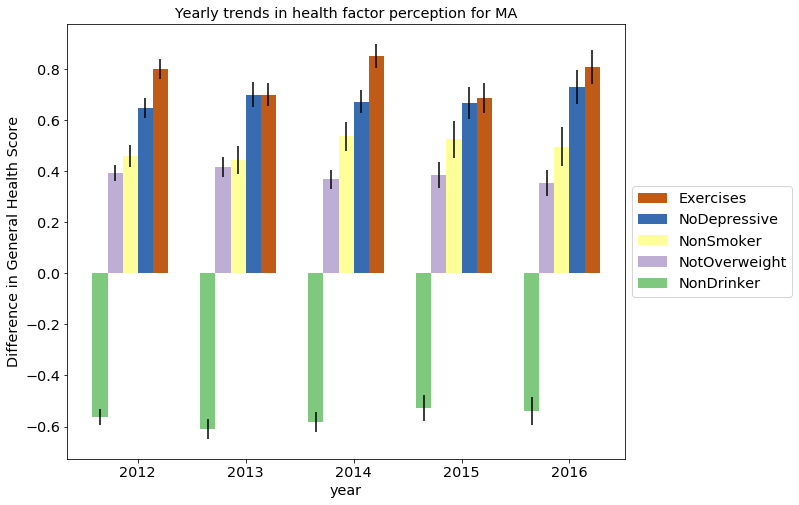

In [12]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

space = 0.3

bar_means = [np.mean([agg_results[year][factor] for year in years]) for factor in bar_factors]
variables = [factor for _,factor in sorted(zip(bar_means, bar_factors))]
groups = years

n = len(variables)

width = (1 - space) / (len(variables))

for i, var in enumerate(variables):
    values = [agg_results[year][var] for year in years]
    err = [agg_results[year][var + '_err'] for year in years]
    pos = [j - (1 - space) / 2. + i * width for j in range(1, len(groups)+1)]
    ax.bar(pos, values, width=width, label=var, color=cm.Accent(float(i) / n), yerr=err)

ax.set_xticks(range(1, len(groups)+1))
ax.set_xticklabels(groups)
ax.set_xlabel('year')
ax.set_ylabel('Difference in General Health Score')
ax.set_title('Yearly trends in health factor perception for ' + state)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()